## EfficientNet

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import EfficientNetB3

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import datetime

In [2]:
trainImagePath = '../dataSet/splitImages/train'
validationImagePath = '../dataSet/splitImages/val'
testImagePath = '../dataSet/splitImages/test'
checkpointPath = '../testEfficientNet/checkpoints/epoch_{epoch:04d}.h5'
logsPath = '../testEfficientNet/logs/fit/'+ datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
bestCheckpointPath = '../testEfficientNet/model/epoch_{epoch:04d}.h5'
savedModelPath = '../testEfficientNet/model/efficientModel.h5'

batchSize = 32
imageWidth = 300
imageHeight = 300
imageChannel = 3
input_shape = (imageWidth, imageHeight, imageChannel)
n_classes = 50


### 이미지 데이터 생성

ImageDataGenerator (train, validation)

In [3]:
trainDataGen = ImageDataGenerator(rescale=1./255,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  shear_range=0.2,
                                  zoom_range=-0.3,
                                  horizontal_flip=False,
                                  vertical_flip=False,
                                  brightness_range=[0.7, 1.3],
                                  fill_mode='nearest'
                                  )

train set

In [4]:
trainGenSet = trainDataGen.flow_from_directory(
    trainImagePath,
    batch_size=batchSize,
    target_size=(imageWidth,imageHeight),
    class_mode='categorical',
    shuffle=True
)

Found 7108 images belonging to 50 classes.


In [5]:
x_train,y_train = trainGenSet.next()

(300, 300, 3)


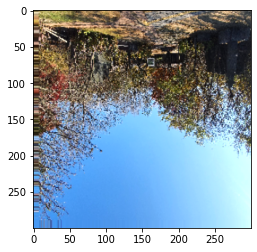

In [6]:
print(x_train[0].shape)
plt.imshow(x_train[3])
plt.show()

validation set

In [7]:
validationGenSet = trainDataGen.flow_from_directory(
    validationImagePath,
    batch_size=batchSize,
    target_size=(imageWidth,imageHeight),
    class_mode='categorical'
)

Found 870 images belonging to 50 classes.


ImageDataGenerator (train, validation)

In [8]:
testDataGen = ImageDataGenerator(rescale=1./255)

test set

In [9]:
testGenSet = testDataGen.flow_from_directory(
    testImagePath,
    batch_size=batchSize,
    target_size=(imageWidth,imageHeight),
    class_mode='categorical'
)

Found 929 images belonging to 50 classes.


In [10]:
model = EfficientNetB3(include_top=False, input_shape = input_shape, pooling='avg', weights='imagenet')

x = model.output
x = Dense(1024, activation='relu' )(x)
x = Dropout(rate=0.5)(x)
x = Dense(512, activation='relu' )(x)
x = Dropout(rate=0.5)(x)
x = Dense(256, activation='relu' )(x)

predictions = Dense(n_classes, activation="softmax")(x)

model_final = tf.keras.models.Model(inputs = model.input, outputs = predictions)

model_final.summary()

2022-06-21 15:23:12.861597: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-21 15:23:14.316427: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13690 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 300, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 300, 300, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 300, 300, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 300, 300, 3)  0           ['normalization[0][0]']      

 block2a_expand_conv (Conv2D)   (None, 150, 150, 14  3456        ['block1b_add[0][0]']            
                                4)                                                                
                                                                                                  
 block2a_expand_bn (BatchNormal  (None, 150, 150, 14  576        ['block2a_expand_conv[0][0]']    
 ization)                       4)                                                                
                                                                                                  
 block2a_expand_activation (Act  (None, 150, 150, 14  0          ['block2a_expand_bn[0][0]']      
 ivation)                       4)                                                                
                                                                                                  
 block2a_dwconv_pad (ZeroPaddin  (None, 151, 151, 14  0          ['block2a_expand_activation[0][0]
 g2D)     

 ivation)                                                                                         
                                                                                                  
 block2c_dwconv (DepthwiseConv2  (None, 75, 75, 192)  1728       ['block2c_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block2c_bn (BatchNormalization  (None, 75, 75, 192)  768        ['block2c_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block2c_activation (Activation  (None, 75, 75, 192)  0          ['block2c_bn[0][0]']             
 )                                                                                                
          

                                                                                                  
 block3b_activation (Activation  (None, 38, 38, 288)  0          ['block3b_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block3b_se_squeeze (GlobalAver  (None, 288)         0           ['block3b_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block3b_se_reshape (Reshape)   (None, 1, 1, 288)    0           ['block3b_se_squeeze[0][0]']     
                                                                                                  
 block3b_se_reduce (Conv2D)     (None, 1, 1, 12)     3468        ['block3b_se_reshape[0][0]']     
          

 )                                                                                                
                                                                                                  
 block4a_se_squeeze (GlobalAver  (None, 288)         0           ['block4a_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block4a_se_reshape (Reshape)   (None, 1, 1, 288)    0           ['block4a_se_squeeze[0][0]']     
                                                                                                  
 block4a_se_reduce (Conv2D)     (None, 1, 1, 12)     3468        ['block4a_se_reshape[0][0]']     
                                                                                                  
 block4a_se_expand (Conv2D)     (None, 1, 1, 288)    3744        ['block4a_se_reduce[0][0]']      
          

                                                                                                  
 block4c_se_excite (Multiply)   (None, 19, 19, 576)  0           ['block4c_activation[0][0]',     
                                                                  'block4c_se_expand[0][0]']      
                                                                                                  
 block4c_project_conv (Conv2D)  (None, 19, 19, 96)   55296       ['block4c_se_excite[0][0]']      
                                                                                                  
 block4c_project_bn (BatchNorma  (None, 19, 19, 96)  384         ['block4c_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block4c_drop (Dropout)         (None, 19, 19, 96)   0           ['block4c_project_bn[0][0]']     
          

                                                                                                  
 block4e_project_bn (BatchNorma  (None, 19, 19, 96)  384         ['block4e_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block4e_drop (Dropout)         (None, 19, 19, 96)   0           ['block4e_project_bn[0][0]']     
                                                                                                  
 block4e_add (Add)              (None, 19, 19, 96)   0           ['block4e_drop[0][0]',           
                                                                  'block4d_add[0][0]']            
                                                                                                  
 block5a_expand_conv (Conv2D)   (None, 19, 19, 576)  55296       ['block4e_add[0][0]']            
          

                                                                                                  
 block5c_expand_bn (BatchNormal  (None, 19, 19, 816)  3264       ['block5c_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block5c_expand_activation (Act  (None, 19, 19, 816)  0          ['block5c_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block5c_dwconv (DepthwiseConv2  (None, 19, 19, 816)  20400      ['block5c_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block5c_b

 ivation)                                                                                         
                                                                                                  
 block5e_dwconv (DepthwiseConv2  (None, 19, 19, 816)  20400      ['block5e_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block5e_bn (BatchNormalization  (None, 19, 19, 816)  3264       ['block5e_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block5e_activation (Activation  (None, 19, 19, 816)  0          ['block5e_bn[0][0]']             
 )                                                                                                
          

 )                              )                                                                 
                                                                                                  
 block6b_activation (Activation  (None, 10, 10, 1392  0          ['block6b_bn[0][0]']             
 )                              )                                                                 
                                                                                                  
 block6b_se_squeeze (GlobalAver  (None, 1392)        0           ['block6b_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block6b_se_reshape (Reshape)   (None, 1, 1, 1392)   0           ['block6b_se_squeeze[0][0]']     
                                                                                                  
 block6b_s

 )                              )                                                                 
                                                                                                  
 block6d_se_squeeze (GlobalAver  (None, 1392)        0           ['block6d_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block6d_se_reshape (Reshape)   (None, 1, 1, 1392)   0           ['block6d_se_squeeze[0][0]']     
                                                                                                  
 block6d_se_reduce (Conv2D)     (None, 1, 1, 58)     80794       ['block6d_se_reshape[0][0]']     
                                                                                                  
 block6d_se_expand (Conv2D)     (None, 1, 1, 1392)   82128       ['block6d_se_reduce[0][0]']      
          

 agePooling2D)                                                                                    
                                                                                                  
 block6f_se_reshape (Reshape)   (None, 1, 1, 1392)   0           ['block6f_se_squeeze[0][0]']     
                                                                                                  
 block6f_se_reduce (Conv2D)     (None, 1, 1, 58)     80794       ['block6f_se_reshape[0][0]']     
                                                                                                  
 block6f_se_expand (Conv2D)     (None, 1, 1, 1392)   82128       ['block6f_se_reduce[0][0]']      
                                                                                                  
 block6f_se_excite (Multiply)   (None, 10, 10, 1392  0           ['block6f_activation[0][0]',     
                                )                                 'block6f_se_expand[0][0]']      
          

 block7b_se_excite (Multiply)   (None, 10, 10, 2304  0           ['block7b_activation[0][0]',     
                                )                                 'block7b_se_expand[0][0]']      
                                                                                                  
 block7b_project_conv (Conv2D)  (None, 10, 10, 384)  884736      ['block7b_se_excite[0][0]']      
                                                                                                  
 block7b_project_bn (BatchNorma  (None, 10, 10, 384)  1536       ['block7b_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block7b_drop (Dropout)         (None, 10, 10, 384)  0           ['block7b_project_bn[0][0]']     
                                                                                                  
 block7b_a

In [11]:
model_final.compile(loss='categorical_crossentropy',
              optimizer= 'sgd',
              metrics=['accuracy'])

In [12]:
checkpoint = ModelCheckpoint(
                        checkpointPath, monitor='val_loss', verbose=0, save_best_only=False,
                        save_weights_only=False, mode='auto', save_freq='epoch'
                    )


In [13]:
earlyStopping = [
                    EarlyStopping(monitor='val_loss',verbose=0, patience=10, ),
                    ModelCheckpoint( bestCheckpointPath, monitor='val_loss', save_best_only=True )
                ]

In [14]:
tensorboard = tf.keras.callbacks.TensorBoard(logsPath)

In [15]:
epochs = 200
history = model_final.fit(
    trainGenSet,
    epochs=epochs,
    validation_data=validationGenSet,
    callbacks=[checkpoint,earlyStopping, tensorboard],
    verbose=1
)

Epoch 1/200


2022-06-21 15:23:37.641223: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8303


223/223 [==============================] - 771s 3s/step - loss: 3.8709 - accuracy: 0.0390 - val_loss: 3.9036 - val_accuracy: 0.0184
Epoch 2/200
223/223 [==============================] - 774s 3s/step - loss: 3.6218 - accuracy: 0.1117 - val_loss: 3.8742 - val_accuracy: 0.0368
Epoch 3/200
223/223 [==============================] - 781s 4s/step - loss: 2.7698 - accuracy: 0.3613 - val_loss: 3.9081 - val_accuracy: 0.0333
Epoch 4/200
223/223 [==============================] - 767s 3s/step - loss: 1.5096 - accuracy: 0.6652 - val_loss: 3.8162 - val_accuracy: 0.0747
Epoch 5/200
223/223 [==============================] - 771s 3s/step - loss: 0.6893 - accuracy: 0.8445 - val_loss: 0.9652 - val_accuracy: 0.7667
Epoch 6/200
223/223 [==============================] - 789s 4s/step - loss: 0.3464 - accuracy: 0.9190 - val_loss: 1.5531 - val_accuracy: 0.6115
Epoch 7/200
223/223 [==============================] - 768s 3s/step - loss: 0.2018 - accuracy: 0.9541 - val_loss: 0.5782 - val_accuracy: 0.8414
Epoc

In [16]:
scores = model_final.evaluate(testGenSet)
print(scores)

30/30 [==============================] - 75s 2s/step - loss: 3.8696e-04 - accuracy: 1.0000
[0.00038695629336871207, 1.0]


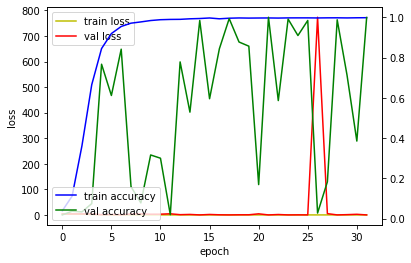

In [17]:
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label = 'train loss')
loss_ax.plot(history.history['val_loss'], 'r', label = 'val loss')
acc_ax.plot(history.history['accuracy'], 'b', label = 'train accuracy')
acc_ax.plot(history.history['val_accuracy'], 'g', label = 'val accuracy')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_xlabel('accuracy')

loss_ax.legend(loc = 'upper left')
acc_ax.legend(loc = 'lower left')

plt.show()

In [18]:
model.save(savedModelPath)

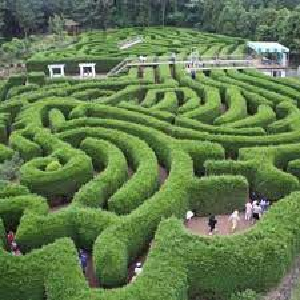

In [19]:
testImage = load_img("../testImage.jpg", target_size = (imageHeight, imageWidth))
testImage

In [20]:
testImage = img_to_array(testImage)
testImage = testImage/255.0

print(testImage)

[[[0.2627451  0.32941177 0.30588236]
  [0.22745098 0.29411766 0.27058825]
  [0.22745098 0.29411766 0.27058825]
  ...
  [0.36862746 0.4392157  0.45490196]
  [0.36862746 0.4392157  0.45490196]
  [0.36862746 0.44705883 0.4392157 ]]

 [[0.29411766 0.36078432 0.3372549 ]
  [0.20392157 0.27058825 0.24705882]
  [0.20392157 0.27058825 0.24705882]
  ...
  [0.32156864 0.39215687 0.4       ]
  [0.32156864 0.39215687 0.4       ]
  [0.29803923 0.3764706  0.36862746]]

 [[0.29411766 0.36078432 0.3372549 ]
  [0.20392157 0.27058825 0.24705882]
  [0.20392157 0.27058825 0.24705882]
  ...
  [0.32156864 0.39215687 0.4       ]
  [0.32156864 0.39215687 0.4       ]
  [0.29803923 0.3764706  0.36862746]]

 ...

 [[0.14509805 0.24313726 0.1254902 ]
  [0.14509805 0.24313726 0.1254902 ]
  [0.14509805 0.24313726 0.1254902 ]
  ...
  [0.50980395 0.5568628  0.4       ]
  [0.50980395 0.5568628  0.4       ]
  [0.5058824  0.54509807 0.40784314]]

 [[0.14509805 0.24313726 0.1254902 ]
  [0.14509805 0.24313726 0.1254902 ]


In [21]:
confidence = model_final.predict(testImage.reshape((1, imageHeight, imageWidth, imageChannel)))

1/1 [==============================] - 2s 2s/step


In [22]:
for i in range(confidence.shape[1]):
    print(f"{i} 일 확률 = {round(confidence[0][i], 3)}")

print(f"정답은 : {np.argmax(confidence, axis=1)}")

0 일 확률 = 0.0
1 일 확률 = 0.0
2 일 확률 = 0.0
3 일 확률 = 0.0
4 일 확률 = 0.9980000257492065
5 일 확률 = 0.0
6 일 확률 = 0.0
7 일 확률 = 0.0
8 일 확률 = 0.0
9 일 확률 = 0.0
10 일 확률 = 0.0
11 일 확률 = 0.0
12 일 확률 = 0.0
13 일 확률 = 0.0
14 일 확률 = 0.0
15 일 확률 = 0.0
16 일 확률 = 0.0
17 일 확률 = 0.0
18 일 확률 = 0.0
19 일 확률 = 0.0
20 일 확률 = 0.0
21 일 확률 = 0.0
22 일 확률 = 0.0
23 일 확률 = 0.0
24 일 확률 = 0.0
25 일 확률 = 0.0
26 일 확률 = 0.0
27 일 확률 = 0.0
28 일 확률 = 0.0
29 일 확률 = 0.0
30 일 확률 = 0.0
31 일 확률 = 0.0
32 일 확률 = 0.0
33 일 확률 = 0.0
34 일 확률 = 0.0
35 일 확률 = 0.0
36 일 확률 = 0.0
37 일 확률 = 0.0
38 일 확률 = 0.0
39 일 확률 = 0.0
40 일 확률 = 0.0
41 일 확률 = 0.0
42 일 확률 = 0.0
43 일 확률 = 0.0
44 일 확률 = 0.0
45 일 확률 = 0.0
46 일 확률 = 0.0
47 일 확률 = 0.0
48 일 확률 = 0.0
49 일 확률 = 0.0
정답은 : [4]


In [23]:
dfTrain = pd.read_csv('../categoryList.csv', encoding='cp949')
dfTrain.head()

,categoryNumber,categoryName
0,0,감귤박물관
1,1,검멀레동굴
2,2,관덕정
3,3,구엄리돌염전
4,4,김녕미로공원


In [24]:
dfTrain['categoryName'][np.argmax(confidence, axis=1)]

4    김녕미로공원
Name: categoryName, dtype: object